# pycharm启动scrapy项目

1. 在项目的根目录创建一个文件runner.py
```python
from scrapy.cmdline import execute
execute("scrapy crawl baidu".split())  # baidu是爬虫的名字(scrapy genspider baidu baidu.com)
```
2.右键执行这个文件，就能启动scrapy项目

# 中间件

scrapy中的中间件只有两个：
- engine 和下载器之间是：下载器中间件
- engine 和爬虫之间是：spider中间件

常用的是下载器中间件，爬虫中间件用的很少很少。

中间件主要是对请求和响应的过程中，多两者做进一步的加工处理，如添加代理。

## 下载器中间件

中间件是项目中的`middlewares.py`文件，会对请求对象或响应对象进行拦截，做进一步的加工和处理，然后再决定其走向。

下载器中间件的类中有5个方法，需要的就留着. 不需要可以删掉。

具体看看每个方法的作用

**from_crawler**

函数的作用是，给爬虫绑定一些信号，当信号触发时，自动的执行一些方法。就好比烟雾报警器，当有人抽烟时，就会触发报警信号，自动喷水灭火。

比较常用的是在爬虫开始运行时绑定一些动作，在爬虫结束时绑定一些动作。

```python
@classmethod
def from_crawler(cls, crawler):
    # This method is used by Scrapy to create your spiders.
    s = cls()  # 创建当前类的对象 -> 理解成每个函数中的self就可以了
    crawler.signals.connect(s.spider_opened, signal=signals.spider_opened)  # 爬虫开始运行的信号，绑定了s.spider_opened方法，当爬虫运启动时，自动执行该方法
    return s
```

细心的就会发现该类中有spider_opened函数，就打印了一行log
```python
    def spider_opened(self, spider):
        spider.logger.info('Spider opened: %s' % spider.name)
```

其内置的信号有：
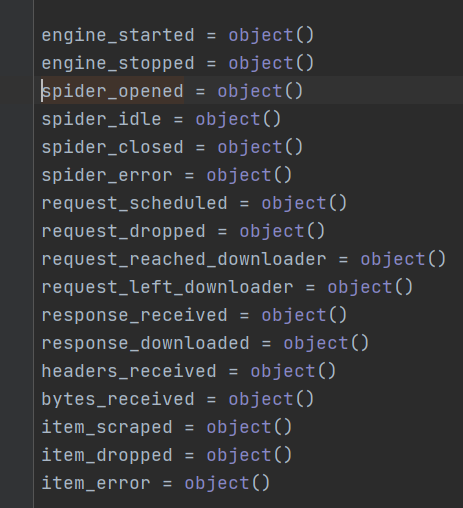

绑定一些信号来看看效果
1. middlewares.py文件
```python
class ZhongDownloaderMiddleware:
    @classmethod
    def from_crawler(cls, crawler):
        # This method is used by Scrapy to create your spiders.
        s = cls()
        crawler.signals.connect(s.spider_opened, signal=signals.spider_opened)  # 爬虫启动信号绑定
        crawler.signals.connect(s.spider_closed, signal=signals.spider_closed)  # 爬虫结束信号绑定
        return s

    def spider_opened(self, spider):
        print('Spider opened: %s' % spider.name)

    def spider_closed(self, spider):
        print('Spider opened: %s' % spider.name)

```


2. settings.py文件, 打开中间件的配置

```python
BOT_NAME = 'zhong'

SPIDER_MODULES = ['zhong.spiders']
NEWSPIDER_MODULE = 'zhong.spiders'
LOG_LEVEL = 'WARNING'


# Crawl responsibly by identifying yourself (and your website) on the user-agent
USER_AGENT = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36"

# Obey robots.txt rules
ROBOTSTXT_OBEY = False

# Enable or disable downloader middlewares
# See https://docs.scrapy.org/en/latest/topics/downloader-middleware.html
DOWNLOADER_MIDDLEWARES = {
   'zhong.middlewares.ZhongDownloaderMiddleware': 543,
}

```

3. 项目个根目录创建runner文件
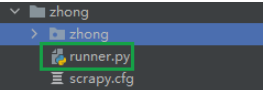
```python
from scrapy.cmdline import execute
execute("scrapy crawl baidu".split())
```

4.启动爬虫
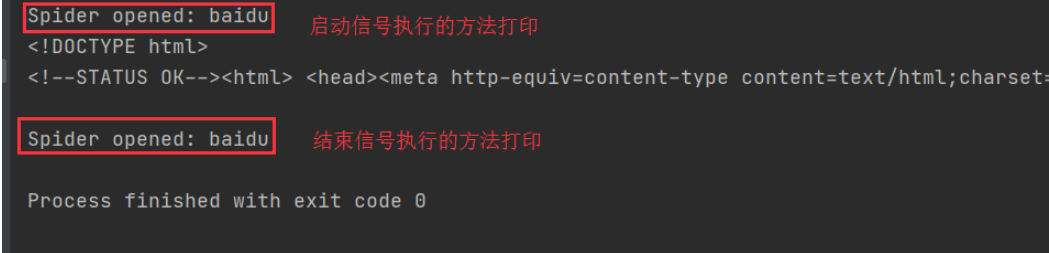

**process_request**

处理请求的,请求在发送给下载器的时候. 自动执行的函数，在该函数中可以对请求拦截下来，做处理。

```python
    def process_request(self, request, spider):  # request是当前请求对象
        # Called for each request that goes through the downloader
        # middleware.

        # Must either:
        # - return None: continue processing this request
        # - or return a Response object
        # - or return a Request object
        # - or raise IgnoreRequest: process_exception() methods of
        #   installed downloader middleware will be called
        return None
```

这个方法限制了返回值，必须是给定的某一个：
- return None  请求继续向下一个下载器中间件走，最终走到下载器
- return Response obj 停下来. 这个请求就不会走下载器, 而是直接把响应对象给到引擎，然后给到爬虫
- return Request obj 停下来.这个请求也不会走下载器. 而是直接把请求对象给到引擎，然后到调度器进行去重，加入队列
- 抛出异常，会执行process_exception方法

中间件有优先级，其数字越小优先级越高，数字小的离引擎近，请求时从engine到下载器，经过中间件时，按数字由小到大，即离引擎近中间件的process_request方法先经过。

**process_response**

在响应对象反馈给引擎的时候自动执行, 可以判断各种状态码. 判断返回的数据是否正常

```python
    def process_response(self, request, response, spider):
        # Called with the response returned from the downloader.

        # Must either;
        # - return a Response object
        # - return a Request object
        # - or raise IgnoreRequest
        return response
```

这个方法限制了返回值，必须是给定的某一个：
- return a Response obj  把响应对象返回, 继续往回走, 走下一个中间件，最后走到engine
- return a Request obj  返回一个请求对象,直接把请求对象发给引擎(跳过后续的中间件), 引擎继续走调度器、去重、加入队列
- 抛出异常，会执行process_exception方法

 从下载器到engine，数字越大离下载器越近，按数字由大到小经过中间件的process_response方法，即离下载器近的先经过。

**process_exception**

这个没啥说的，就是在process_request和process_response方法抛出异常时会调用这个函数，一般也就用来打印log。

## 下载器中间件的简单使用

下载器中间件代码修改，加上一些打印
```python
class ZhongDownloaderMiddleware:
    @classmethod
    def from_crawler(cls, crawler):
        # This method is used by Scrapy to create your spiders.
        s = cls()
        crawler.signals.connect(s.spider_opened, signal=signals.spider_opened)  # 爬虫启动信号绑定
        crawler.signals.connect(s.spider_closed, signal=signals.spider_closed)  # 爬虫结束信号绑定
        return s

    def process_request(self, request, spider):
        print("我是请求来的", request.url)
        return None

    def process_response(self, request, response, spider):
        print("我是下载器来的", response.url)
        return response

    def process_exception(self, request, exception, spider):
        pass

    def spider_opened(self, spider):
        print('Spider opened: %s' % spider.name)

    def spider_closed(self, spider):
        print('Spider opened: %s' % spider.name)

```
在爬虫代码中打印
```python
class BaiduSpider(scrapy.Spider):
    name = 'baidu'
    allowed_domains = ['baidu.com']
    start_urls = ['http://www.baidu.com/']

    def parse(self, resp, **kwargs):
        print(resp.url)  # 打印访问到的页面的url
```

执行结果

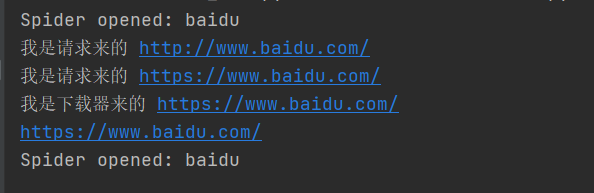

会发现和预想的不一样，process_request的打印输出了两次。

其原因是，百度的服务器重定向了，scrapy有一个处理重定向的中间件，会处理重定向的响应：
- 仔细观察两次process_request打印的url，第一个是http，第二个是https，这是百度服务器的行为
- scrapy处理处理重定向的中间件数字是790，我们的中间件数字是543，所以先经过了scrapy中间件
- scrapy中间件的process_response，检测到有重定向，就会返回一个Request对象
- 在process_response方法中返回一个Request对象，意味着后续的中间件不会再经过，直接将Request对象给引擎，再到调度器。

所以出现了上图的效果，如果我们把`ZhongDownloaderMiddleware`的数字设置为791，就会打印我们预想的结果
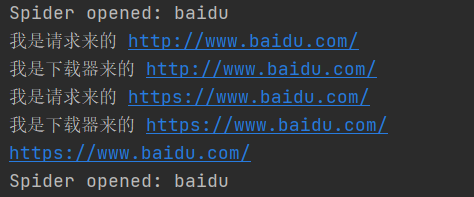

## 下载器中间件的用途

当每次请求都要做处理时，就可以使用中间件。

**1.随机选择User Agent**

User Agent大全：`http://useragentstring.com/pages/useragentstring.php?name=Chrome`

可以从上面网址中，随机选择几个，在每次请求发送时随机更换UA。

在setting.py文件中配置一些UA
```python
User_Agents = [
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.84 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:101.0) Gecko/20100101 Firefox/101.0",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:99.0) Gecko/20100101 Firefox/99.0"
]
```

在下载器中为每个请求配置UA
```python
class ZhongDownloaderMiddleware:
    def process_request(self, request, spider):
        ua = random.choice(User_Agents)
        request.headers["User_Agent"] = ua
        return None
```

在爬虫中打印请求头信息
```python
class BaiduSpider(scrapy.Spider):
    name = 'baidu'
    allowed_domains = ['baidu.com']
    start_urls = ['http://www.baidu.com/']

    def parse(self, resp, **kwargs):
        print(resp.request.headers)  # 打印请求头
```

效果是每次请求都随机选择一个UA。

**2.每次请求添加代理**

可以结合之前的免费线程池，每次请求随机选择一个代理IP给请求。
```python
# 知道代理Ip时，添加代理方式
request.meta['proxy'] = "http://proxy.yourproxy:8001"

# 如果代理ip有账号密码，就需要再加上下面内容
# proxy_user_pass = "USERNAME:PASSWORD"
# encoded_user_pass = base64.encodestring(proxy_user_pass)
# request.headers['Proxy-Authorization'] = 'Basic ' + encoded_user_pass

```

但是ip直接暴露给用户的方式，有些人会一直使用这一个IP，导致这个IP可用性很差，即使是购买的ip，ip肯定是有多个人同时使用的，有些IP的体验感仍然很差。

我们可以购买隧道代理，其不会把IP暴露出来，具体使用哪个ip由服务商确定，所以其体验感相对于IP暴露出来的方式来说会好一点。

***scrapy使用隧道代理***：

选择快代理的隧道代理，具体使用看其网站的隧道代理使用文档。
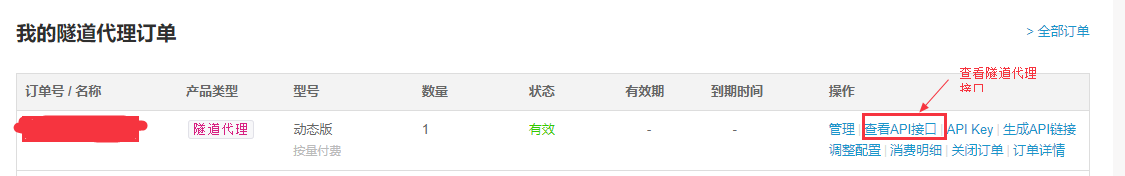
查看代码样例
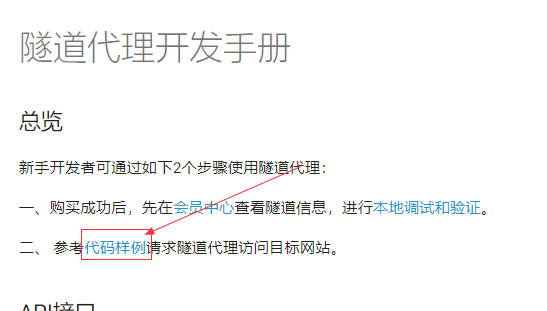
找到scrapy的样例代码
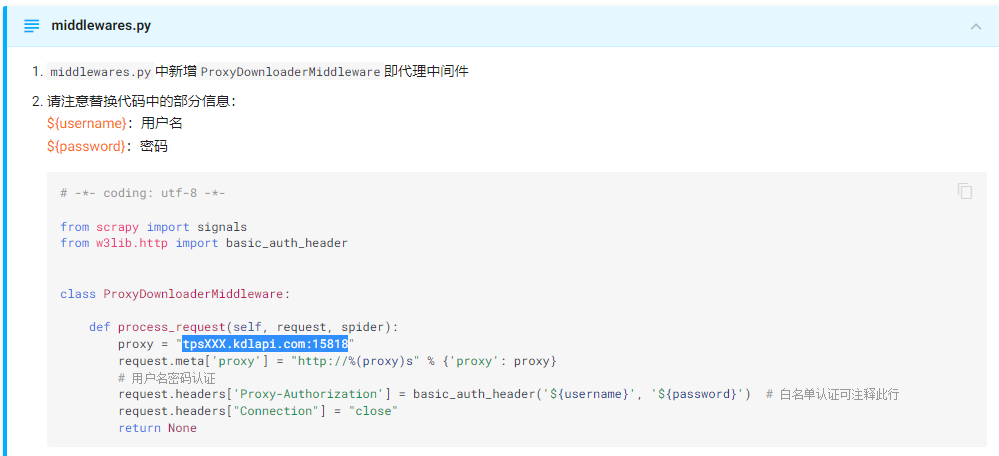

上图中的proxy username password在
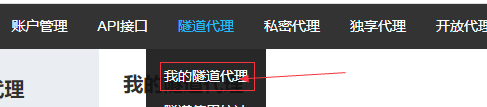
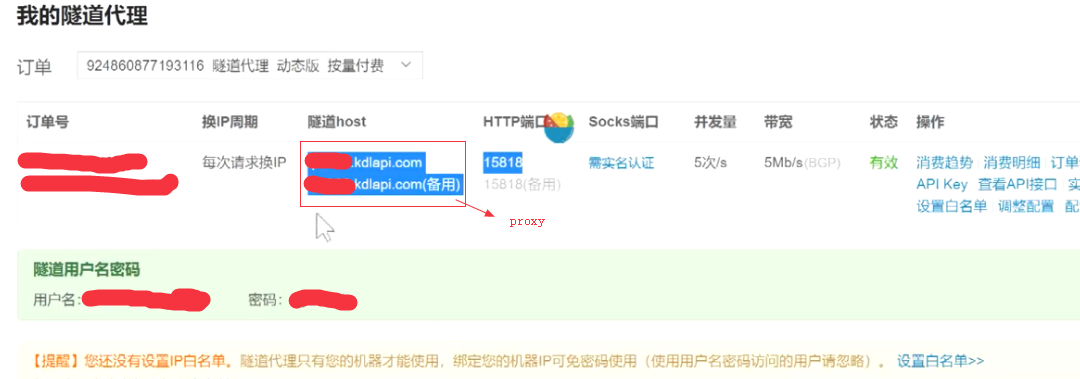

代码实现：
```python
class ZhongDownloaderMiddleware:
    def process_request(self, request, spider):
        ua = random.choice(User_Agents)
        request.headers["User_Agent"] = ua
        proxy = "tps365.kdlapi.com:15818"  # 更换个隧道
        request.meta['proxy'] = "http://%(proxy)s" % {'proxy': proxy}
        # 用户名密码认证
        request.headers['Proxy-Authorization'] = basic_auth_header('t14860877193391', 'kg72z3rb')  # 白名单认证可注释此行
        request.headers["Connection"] = "close"
        return None

    def process_response(self, request, response, spider):
        # 它不对劲的时候。 是不是应该重新发送请求
        # 可能需要在返回的时候. 做进一步的判断. 判断该次请求是否是理想中的响应体
        if "百度安全验证" in response.text:  # 被检测出来了，重新发送请求
            # 回去。 重新发送请求
            # 不需要去重
            request.dont_filter = True  # (调度器)不去重，一定要加这个，不然调度器去掉重复就不会重新发送了
            return request  # 给engine然后再到调度去，dont_filter=True，不会去重，直接加入队列
        return response
```

```python
class BaiduSpider(scrapy.Spider):
    name = 'baidu'
    allowed_domains = ['baidu.com']
    start_urls = ['http://www.baidu.com/s?wd=ip']

    def parse(self, resp, **kwargs):
        print(resp.text)
```

## scrapy 结合 selenium

当有些网站的有很复杂的反扒措施，我们不想去逆向，就可以结合selenium跳过反扒措施的网页，直接拿到页面的Element。

或者不想看登录的逆向，可以直接selenium登录。拿到cookie,每次请求的时候添加cookie.

**1.实战1**

网址：